In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
df=pd.read_csv("Tetuan City power consumption.csv",parse_dates=["DateTime"],index_col=[0])
df.shape

(52416, 6)

In [3]:
df.head()

,temperature,humidity,wind speed,General diffuse flow,Diffuse flow,Total electricity
DateTime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,63650.44627


In [4]:
df_for_training=df[-3000:-600]
df_for_testing=df[-600:]
print(df_for_training.shape)
print(df_for_testing.shape)

(2400, 6)
(600, 6)


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [6]:
df_for_testing_scaled=scaler.transform(df_for_testing)

In [7]:
df_for_training_scaled.shape

(2400, 6)

In [8]:
df_for_testing_scaled.shape

(600, 6)

In [9]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,5])
    return np.array(dataX),np.array(dataY)        

In [10]:
trainX,trainY=createXY(df_for_training_scaled,10)
testX,testY=createXY(df_for_testing_scaled,10)

In [11]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [12]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(10,6)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [12],
              'epochs' : [10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [13]:
import time
t1 = time.perf_counter()
grid_search = grid_search.fit(trainX,trainY)
t2 = time.perf_counter()
total_time = (t2-t1)*1000

Epoch 1/10
100/100 [==============================] - 3s 10ms/step - loss: 0.0291 - val_loss: 0.0062
Epoch 2/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 8/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 9/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/10
100/100 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 1/10
100/10

In [14]:
print(total_time)

52065.950899999996


In [15]:
my_model=grid_search.best_estimator_.model
my_model

In [16]:
prediction=my_model.predict(testX)
#print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)


Prediction Shape- (590, 1)


In [17]:
prediction_copies_array = np.repeat(prediction,6, axis=-1)

In [18]:
prediction_copies_array.shape

(590, 6)

In [19]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),6)))
pred = pred[:,5]

In [20]:
original_copies_array = np.repeat(testY,6, axis=-1)
original_copies_array.shape
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),6)))[:,5]

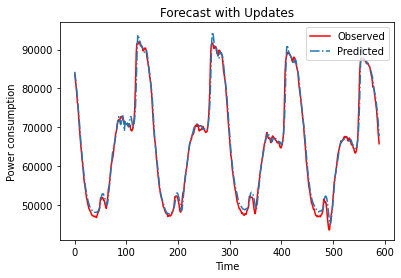

In [21]:
plt.plot(original, color = 'red', label = 'Observed')
plt.plot(pred, '-.', label = 'Predicted')
plt.title('Forecast with Updates')
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.legend()
plt.show()

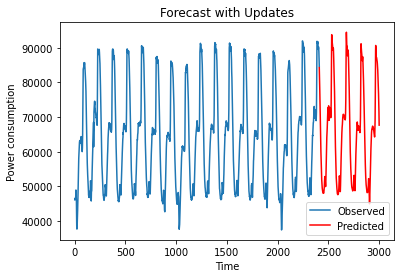

In [22]:
ori = np.array(df[-3000:-590])[:,5]
x_ori = np.linspace(1,2410,2410)
x_pred = np.linspace(2410,3000,590)
plt.plot(x_ori,ori,label = 'Observed')
plt.plot(x_pred,pred,color = 'red',label = 'Predicted')
plt.title('Forecast with Updates')
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.legend()
plt.show()

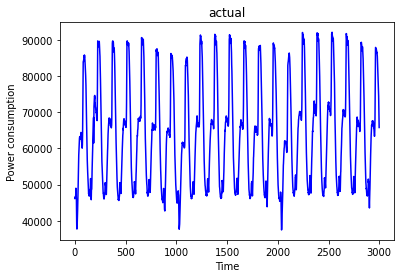

In [23]:
full_ori = np.array(df[-3000:])[:,5]
plt.plot(full_ori,color='blue')
plt.title('actual')
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.show()

In [24]:
error = original[:-1]-pred[1:]

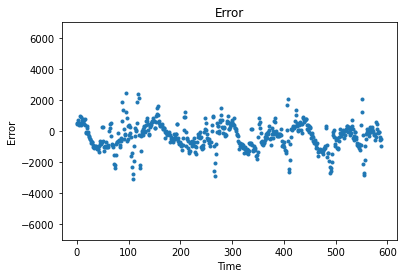

In [25]:
plt.plot(error,'.')
plt.ylim([-7000,7000])
plt.title('Error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

In [26]:
rootMeanSquaredError = np.power(np.sum(np.power(error,2))/len(error),0.5)
print(rootMeanSquaredError)

886.2510778458911


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
my_model.save('Model_future_value.h5')

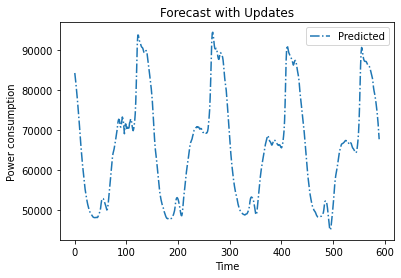

In [29]:
import tensorflow as tf
new_model = tf.keras.models.load_model('Model_future_value.h5')
prediction=new_model(testX)
prediction_copies_array = np.repeat(prediction,6, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),6)))
pred = pred[:,5]
plt.plot(pred, '-.', label = 'Predicted')
plt.title('Forecast with Updates')
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.legend()
plt.show()